# 🏭 Dardanel Üretim Hattı Dinamik Vardiya Planlama

## 🎯 Problem Tanımı

Dardanel firması, günde 3 vardiya ile faaliyet gösteren bir üretim tesisine sahiptir. Üretim hattı:

- 👷 100 çalışan
- 🛠 10 istasyon
- ⏱ 3 vardiya: Sabah (06:00–14:00), Öğle (14:00–22:00), Gece (22:00–06:00)

## 📋 Kısıtlar

1. **Çalışanların Vardiya Uyumluluğu**
   - Her çalışan belirli vardiyalarda çalışabilir.
   - Gece vardiyası yalnızca belli personel tarafından yapılabilir.

2. **İşçi Sınırlamaları**
   - Her çalışan yalnızca bir vardiyada çalışabilir.
   - Maksimum çalışma süresi: 8 saat/gün

3. **İstasyon Gereklilikleri**
   - Her istasyonun vardiya başına belirli bir çalışan ihtiyacı vardır.
   - Aynı istasyonda birden fazla kişi çalışabilir.

4. **Geçiş Süresi Cezaları**
   - İstasyonlar arasında geçiş süresi (setup time) vardır.
   - Aynı gün içinde farklı istasyonlarda çalışan kişiler için cezalandırılır.

5. **Tercih Edilen Tekrar Atama**
   - Aynı çalışanın ardışık günlerde aynı istasyonda çalışması teşvik edilir.

## 🔢 Girdi Parametreleri

- $availability_{w,h} \in \{0,1\}$ → çalışan $w$, vardiya $h$'de çalışabilir mi?
- $qualification_{w,s} \in \{0,1,2,3\}$ → çalışan $w$’nin istasyon $s$'deki yetkinliği
- $transition\_time_{i,j} \in \mathbb{R}^{+}$ → istasyon $i$'den $j$'ye geçiş süresi
- $demand_{s,h} \in \mathbb{N}$ → istasyon $s$ için vardiya $h$’de ihtiyaç duyulan çalışan sayısı

## 🎯 Amaç Fonksiyonu

$$
\max \left[
\sum_{w,s,h} x_{wsh} \cdot qualification_{ws}
- \lambda_1 \cdot \text{geçiş\_cezaları}
- \lambda_2 \cdot \text{vardiya\_ihlal\_cezaları}
- \lambda_3 \cdot \text{eksik\_personel\_cezaları}
\right]
$$

## 📐 Karar Değişkeni

$$
x_{wsh} \in \{0,1\} \quad \text{→ çalışan } w, \text{istasyon } s, \text{vardiya } h'ye atanmış mı?
$$

## 📌 Kısıt Denklemeleri

1. **Bir kişi birden fazla vardiyada çalışamaz:**
$$
\sum_{s,h} x_{wsh} \leq 1 \quad \forall w
$$

2. **Vardiya uygunluk kısıtı:**
$$
x_{wsh} \leq availability_{wh} \quad \forall w, h, s
$$

3. **İstasyon talep kısıtı:**
$$
\sum_w x_{wsh} = demand_{sh} \quad \forall s,h
$$

4. **Geçiş cezası:**
$$
\sum_{i,j} transition\_time_{i,j} \cdot y_{wij} \quad \text{(gerekli ise ek karar değişkeni ile)}
$$

## 🔄 Genişletme: Haftalık Planlama

- Haftalık toplam çalışma gün sayısı:
$$
\sum_{g=1}^{7} \sum_{s,h} x_{wsh}^{(g)} \leq 5 \quad \forall w
$$

- Yorgunluk modeli:
  - Gece vardiyasından sonra sabah vardiyası önerilmez.
  - Üst üste 3 gece vardiyası → verimlilik düşer.

## 🚀 Gerçek Dünya Uyumlandırmaları

- Sosyal mesafe nedeniyle bazı istasyonların kapasitesi yarıya düşebilir.
- Vardiya başına güvenlik personeli zorunlu olabilir.
- Yeni işe başlayanlar sadece belirli istasyonlarda görevlendirilebilir.

## 🧠 Uygulanacak Yöntem

- QUBO Modelleme (Ocean SDK)
- Alternatif: Google OR-Tools ile Mixed-Integer Programming
- Simüle Edilebilir: Monte Carlo veya Agent-based Yaklaşım

## 📈 Uygulama Fırsatları

- Günlük vardiya çizelgesi optimizasyonu
- Acil durum senaryoları (işçi eksikliği, COVID karantinası vs.)
- Hafta bazında otomatik çizelgeleme

---



In [2]:
import numpy as np
import pandas as pd
from dimod import BinaryQuadraticModel
from neal import SimulatedAnnealingSampler

# Parametreler
n_workers = 20
n_stations = 5
n_shifts = 2

np.random.seed(42)

# Vardiya uygunluğu (1 = çalışabilir, 0 = çalışamaz)
availability = np.random.choice([0, 1], size=(n_workers, n_shifts), p=[0.1, 0.9])

# Yetkinlik matrisi (0–3 arası verimlilik skoru)
qualification = np.random.randint(1, 4, size=(n_workers, n_stations))

# İstasyon ihtiyaçları: her vardiyada 1 kişi
demand = np.full((n_stations, n_shifts), 1)

# QUBO modeli başlat
bqm = BinaryQuadraticModel('BINARY')
penalty = 1.0
variables = {}

# Karar değişkenleri ve amaç fonksiyonu: Verimliliği maksimize et
for w in range(n_workers):
    for s in range(n_stations):
        for h in range(n_shifts):
            var = f"x_{w}_{s}_{h}"
            variables[(w, s, h)] = var
            if availability[w, h]:
                bqm.add_variable(var, -qualification[w, s])  # Maksimizasyon için eksi
            else:
                bqm.add_variable(var, penalty * 5)  # çalışamayacağı vardiya → ceza

# Her işçi yalnızca bir yerde çalışmalı
for w in range(n_workers):
    relevant = [variables[(w, s, h)] for s in range(n_stations) for h in range(n_shifts)]
    for i in range(len(relevant)):
        bqm.add_variable(relevant[i], penalty)
        for j in range(i + 1, len(relevant)):
            bqm.add_interaction(relevant[i], relevant[j], penalty)

# Her istasyona her vardiyada sadece bir çalışan
for s in range(n_stations):
    for h in range(n_shifts):
        relevant = [variables[(w, s, h)] for w in range(n_workers)]
        for i in range(len(relevant)):
            bqm.add_variable(relevant[i], penalty)
            for j in range(i + 1, len(relevant)):
                bqm.add_interaction(relevant[i], relevant[j], penalty)

# Çözümleme
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)
best = sampleset.first.sample

# Sonuçları yazdır
assignments = [(int(k.split('_')[1]), int(k.split('_')[2]), int(k.split('_')[3]))
               for k, v in best.items() if v == 1]

df_result = pd.DataFrame(assignments, columns=['Çalışan', 'İstasyon', 'Vardiya'])

# Beceri Matrisi
print("\n📊 Beceri Matrisi (İşçi x İstasyon):")
df_skill = pd.DataFrame(qualification, columns=[f"İstasyon_{i}" for i in range(n_stations)])
df_skill.index = [f"İşçi_{i}" for i in range(n_workers)]
print(df_skill)

# Atamalar
print("\n✅ İşçi - İstasyon - Vardiya Atamaları:")
print(df_result)



📊 Beceri Matrisi (İşçi x İstasyon):
         İstasyon_0  İstasyon_1  İstasyon_2  İstasyon_3  İstasyon_4
İşçi_0            3           1           3           3           2
İşçi_1            1           2           2           2           2
İşçi_2            2           2           2           1           3
İşçi_3            2           2           2           2           2
İşçi_4            2           3           3           2           3
İşçi_5            1           2           1           1           2
İşçi_6            3           1           2           1           1
İşçi_7            1           1           3           1           1
İşçi_8            1           3           1           1           3
İşçi_9            3           3           1           3           3
İşçi_10           1           3           1           2           3
İşçi_11           2           1           3           1           2
İşçi_12           1           3           3           2           1
İşçi_13    

In [3]:
import numpy as np
import pandas as pd
from dimod import BinaryQuadraticModel
from neal import SimulatedAnnealingSampler

# Parametreler
n_workers = 100
n_stations = 10
n_shifts = 3

np.random.seed(42)

# 1. Çalışanların hangi vardiyalarda çalışabileceği
availability = np.random.choice([0, 1], size=(n_workers, n_shifts), p=[0.1, 0.9])

# 2. İşçi başına istasyon verimlilik puanları (1-3 arası)
qualification = np.random.randint(1, 4, size=(n_workers, n_stations))

# 3. Her istasyon + vardiya için ihtiyaç: 2 işçi
demand = np.full((n_stations, n_shifts), 2)

# QUBO modeli
bqm = BinaryQuadraticModel('BINARY')
penalty = 1.0
variables = {}

# Amaç fonksiyonu: Verimlilikleri maksimize et
for w in range(n_workers):
    for s in range(n_stations):
        for h in range(n_shifts):
            var = f"x_{w}_{s}_{h}"
            variables[(w, s, h)] = var
            if availability[w, h]:
                bqm.add_variable(var, -qualification[w, s])  # Maksimize için eksi
            else:
                bqm.add_variable(var, penalty * 5)  # çalışamayacağı vardiyaya ceza

# Kısıt 1: Her işçiye sadece bir görev verilsin
for w in range(n_workers):
    relevant = [variables[(w, s, h)] for s in range(n_stations) for h in range(n_shifts)]
    for i in range(len(relevant)):
        bqm.add_variable(relevant[i], penalty)
        for j in range(i + 1, len(relevant)):
            bqm.add_interaction(relevant[i], relevant[j], penalty)

# Kısıt 2: Her istasyon + vardiyada en fazla 2 kişi çalışsın
for s in range(n_stations):
    for h in range(n_shifts):
        relevant = [variables[(w, s, h)] for w in range(n_workers)]
        for i in range(len(relevant)):
            bqm.add_variable(relevant[i], penalty)
            for j in range(i + 1, len(relevant)):
                bqm.add_interaction(relevant[i], relevant[j], penalty)

# QUBO çözümü
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)
best = sampleset.first.sample

# Sonuçları çözümle
assignments = [(int(k.split('_')[1]), int(k.split('_')[2]), int(k.split('_')[3]))
               for k, v in best.items() if v == 1]

df_result = pd.DataFrame(assignments, columns=['Çalışan', 'İstasyon', 'Vardiya'])

# Beceri Matrisi
print("\n📊 Beceri Matrisi (İşçi x İstasyon):")
df_skill = pd.DataFrame(qualification, columns=[f"İstasyon_{i}" for i in range(n_stations)])
df_skill.index = [f"İşçi_{i}" for i in range(n_workers)]
print(df_skill)

# Atama Sonuçları
print("\n✅ İşçi - İstasyon - Vardiya Atamaları:")
print(df_result)



📊 Beceri Matrisi (İşçi x İstasyon):
         İstasyon_0  İstasyon_1  İstasyon_2  İstasyon_3  İstasyon_4  \
İşçi_0            1           2           3           3           3   
İşçi_1            1           3           3           2           3   
İşçi_2            3           3           1           1           1   
İşçi_3            2           2           1           1           1   
İşçi_4            2           1           3           3           2   
...             ...         ...         ...         ...         ...   
İşçi_95           1           2           2           3           2   
İşçi_96           2           1           2           1           1   
İşçi_97           2           2           2           1           1   
İşçi_98           2           1           2           1           2   
İşçi_99           2           3           1           2           2   

         İstasyon_5  İstasyon_6  İstasyon_7  İstasyon_8  İstasyon_9  
İşçi_0            1           2         

In [4]:
# Toplam verimlilik puanını hesapla
total_score = 0
detailed_scores = []

for _, row in df_result.iterrows():
    worker = row["Çalışan"]
    station = row["İstasyon"]
    score = qualification[worker, station]
    total_score += score
    detailed_scores.append((worker, station, row["Vardiya"], score))

# Ayrıntılı tablo
df_score_detail = pd.DataFrame(detailed_scores, columns=["Çalışan", "İstasyon", "Vardiya", "Verimlilik"])

print("📈 Toplam Verimlilik Puanı:", total_score)
print("\n🔍 Detaylı Verimlilik Tablosu:")
print(df_score_detail)


📈 Toplam Verimlilik Puanı: 162

🔍 Detaylı Verimlilik Tablosu:
    Çalışan  İstasyon  Vardiya  Verimlilik
0         0         4        1           3
1        10         5        0           3
2        11         7        0           3
3        13         1        1           3
4        16         6        2           3
5        18         9        1           3
6        19         2        2           3
7        21         7        1           3
8        22         6        1           3
9        23         3        2           3
10       28         2        1           3
11        2         1        2           3
12       30         7        2           3
13       32         5        1           3
14       33         9        2           3
15       36         4        0           3
16       37         9        1           3
17       38         6        1           3
18       41         7        2           3
19       43         6        0           3
20       44         3        1     

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


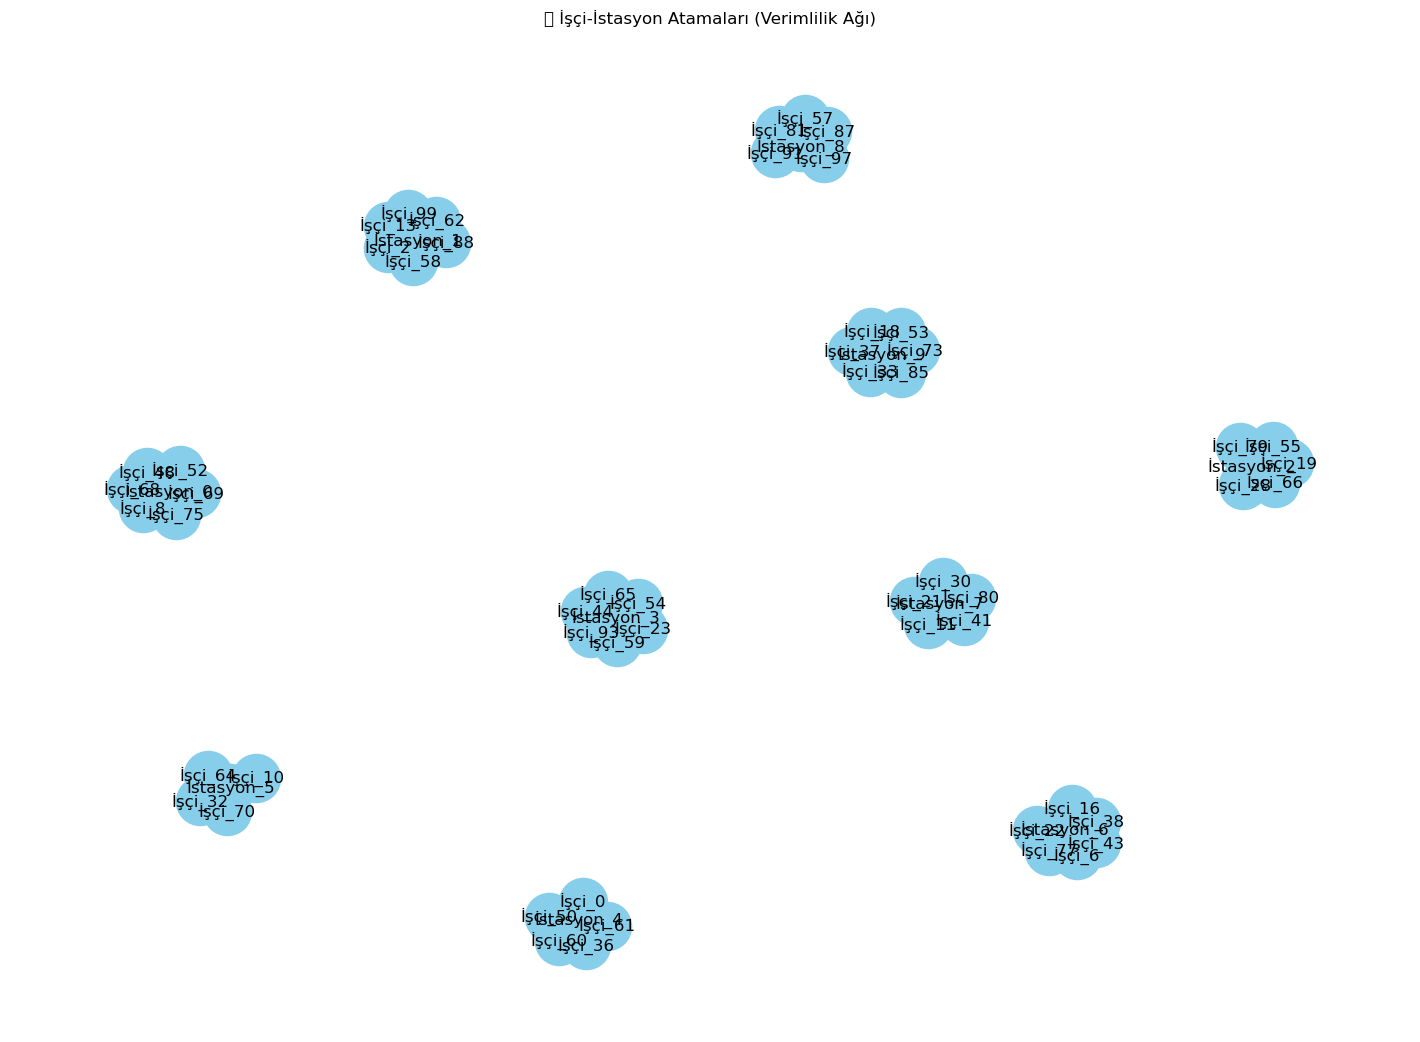

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import random

G = nx.Graph()

# Düğümler
for w in df_result["Çalışan"].unique():
    G.add_node(f"İşçi_{w}", bipartite=0)

for s in df_result["İstasyon"].unique():
    G.add_node(f"İstasyon_{s}", bipartite=1)

# Kenarlar
for _, row in df_score_detail.iterrows():
    G.add_edge(f"İşçi_{row['Çalışan']}", f"İstasyon_{row['İstasyon']}", weight=row["Verimlilik"])

# Çizim
pos = nx.spring_layout(G, seed=42)
edge_labels = nx.get_edge_attributes(G, 'weight')
colors = [random.random() for _ in range(G.number_of_edges())]

plt.figure(figsize=(14, 10))
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=1200, edge_color=colors, width=2, edge_cmap=plt.cm.plasma)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("🔗 İşçi-İstasyon Atamaları (Verimlilik Ağı)")
plt.axis('off')
plt.show()


In [6]:
# Pivot tablo
pivot_vardiya = df_result.groupby(["Vardiya", "İstasyon"]).size().unstack(fill_value=0)

print("📊 Vardiya-İstasyon Doluluk Tablosu:")
print(pivot_vardiya)


📊 Vardiya-İstasyon Doluluk Tablosu:
İstasyon  0  1  2  3  4  5  6  7  8  9
Vardiya                               
0         2  2  1  2  2  1  2  2  1  2
1         2  2  2  2  1  2  2  1  2  2
2         2  2  2  2  2  1  2  2  2  2


In [7]:
# Çoklu beceri analiz eşiği
flex_threshold = 6

worker_flexibility = []

for w in range(n_workers):
    high_skills = np.sum(qualification[w, :] >= 2)
    label = "Multi-skilled" if high_skills >= flex_threshold else "Uzman"
    worker_flexibility.append((w, high_skills, label))

df_flex = pd.DataFrame(worker_flexibility, columns=["Çalışan", "2+ Puanlı İstasyon Sayısı", "Sınıf"])

# Özet
multi_count = df_flex["Sınıf"].value_counts()["Multi-skilled"]
expert_count = df_flex["Sınıf"].value_counts()["Uzman"]

print(f"🧠 Multi-skilled işçi sayısı: {multi_count}")
print(f"🎯 Uzman işçi sayısı: {expert_count}")

print("\n🔍 Esneklik Tablosu:")
print(df_flex.sort_values(by="2+ Puanlı İstasyon Sayısı", ascending=False).head(10))  # ilk 10


🧠 Multi-skilled işçi sayısı: 75
🎯 Uzman işçi sayısı: 25

🔍 Esneklik Tablosu:
    Çalışan  2+ Puanlı İstasyon Sayısı          Sınıf
37       37                         10  Multi-skilled
40       40                         10  Multi-skilled
69       69                         10  Multi-skilled
81       81                          9  Multi-skilled
49       49                          9  Multi-skilled
56       56                          9  Multi-skilled
58       58                          9  Multi-skilled
74       74                          9  Multi-skilled
50       50                          9  Multi-skilled
86       86                          8  Multi-skilled


In [8]:
# Haftalık toplamlar
daily_totals = []

for day in range(7):
    sample = sampler.sample(bqm, num_reads=50)
    best_day = sample.first.sample
    assignments_day = [(int(k.split('_')[1]), int(k.split('_')[2]), int(k.split('_')[3]))
                       for k, v in best_day.items() if v == 1]
    
    total = sum([qualification[w][s] for (w, s, h) in assignments_day])
    daily_totals.append((f"Gün {day+1}", total))

df_week = pd.DataFrame(daily_totals, columns=["Gün", "Toplam Verimlilik"])

print("\n📅 7 Günlük Verimlilik Toplamları:")
print(df_week)



📅 7 Günlük Verimlilik Toplamları:
     Gün  Toplam Verimlilik
0  Gün 1                159
1  Gün 2                168
2  Gün 3                165
3  Gün 4                171
4  Gün 5                165
5  Gün 6                168
6  Gün 7                153


In [9]:
# 10 işçi rastgele izinli
np.random.seed(99)
izinli = np.random.choice(n_workers, size=10, replace=False)
availability_scenario = availability.copy()
availability_scenario[izinli, :] = 0  # izinliler hiç çalışamaz

# Yeni QUBO
bqm_scenario = BinaryQuadraticModel('BINARY')
vars_scenario = {}

for w in range(n_workers):
    for s in range(n_stations):
        for h in range(n_shifts):
            var = f"x_{w}_{s}_{h}"
            vars_scenario[(w, s, h)] = var
            if availability_scenario[w, h]:
                bqm_scenario.add_variable(var, -qualification[w, s])
            else:
                bqm_scenario.add_variable(var, penalty * 5)

# Kısıtlar aynı şekilde uygulanıyor
for w in range(n_workers):
    relevant = [vars_scenario[(w, s, h)] for s in range(n_stations) for h in range(n_shifts)]
    for i in range(len(relevant)):
        bqm_scenario.add_variable(relevant[i], penalty)
        for j in range(i + 1, len(relevant)):
            bqm_scenario.add_interaction(relevant[i], relevant[j], penalty)

for s in range(n_stations):
    for h in range(n_shifts):
        relevant = [vars_scenario[(w, s, h)] for w in range(n_workers)]
        for i in range(len(relevant)):
            bqm_scenario.add_variable(relevant[i], penalty)
            for j in range(i + 1, len(relevant)):
                bqm_scenario.add_interaction(relevant[i], relevant[j], penalty)

# Çözümle
sample_scenario = sampler.sample(bqm_scenario, num_reads=100)
best_scenario = sample_scenario.first.sample

assignments_izinli = [(int(k.split('_')[1]), int(k.split('_')[2]), int(k.split('_')[3]))
                      for k, v in best_scenario.items() if v == 1]

verimlilik_izinli = sum([qualification[w][s] for (w, s, h) in assignments_izinli])

print(f"\n🧪 10 İşçi İzinli Durumda Toplam Verimlilik: {verimlilik_izinli}")
print(f"❌ İzinli İşçiler: {izinli}")



🧪 10 İşçi İzinli Durumda Toplam Verimlilik: 159
❌ İzinli İşçiler: [14 34 30 78 16 15 91 38 10 85]
